### Quanvolutional Neural Networks

**Author:** Andrea Mari  
**Published:** March 24, 2020  
**Last Updated:** January 1, 2024  

---

**Introduction**

In this demo, we implement the Quanvolutional Neural Network (QNN), a quantum machine learning model first introduced by Henderson et al. (2019). The Quanvolutional Neural Network represents an innovative extension of classical convolutional techniques into the quantum domain.

---

**Classical Convolution**

Convolutional Neural Networks (CNNs) are a cornerstone of classical machine learning, especially for image processing tasks. The core idea of CNNs is to apply a convolutional layer that processes data locally rather than globally. Here’s a breakdown:

1. **Local Processing**: Instead of analyzing the entire image in one go, CNNs use small, local regions of the image. A kernel (or filter) is applied to these small regions to extract features.
   
2. **Kernel Application**: The kernel moves across the image, processing each local region independently. This results in an output that is organized into channels, each representing different features extracted from the image.

3. **Output Formation**: The results from the convolution are combined to form a new image-like object, which can then be fed into subsequent layers for further processing and feature extraction.

---

**Quantum Convolution**

The concept of convolution can be adapted to quantum computing by employing quantum variational circuits. Here’s how this adaptation works:

1. **Embedding Regions**: A local region of the input image, such as a 2 × 2 square, is encoded into a quantum circuit. This encoding involves applying parameterized rotations to qubits that are initially in the ground state.

2. **Quantum Computation**: A quantum operation, represented by a unitary matrix \( U \), is performed on the qubits. This unitary operation can be generated either by a variational quantum circuit or a random quantum circuit, as discussed in Ref. [1].

3. **Measurement and Output**: After the quantum computation, the system is measured to obtain classical expectation values. Although these values could be post-processed, this demo directly uses the raw expectation values for simplicity.

4. **Mapping to Output**: Each expectation value from the quantum measurement corresponds to a channel in the output pixel, similar to how each feature map is assigned in a classical convolution layer.

5. **Image Scanning**: By repeating this process over different regions of the input image, the quantum convolution produces a multi-channel output image, which can be processed by additional quantum or classical layers.

---

**Comparison with Classical Convolution**

- **Complex Kernels**: Unlike classical convolutional layers, quantum circuits can potentially generate complex kernels that may be classically intractable. This capability allows for the exploration of more intricate feature extraction mechanisms.

- **Fixed vs. Trainable Kernels**: In this tutorial, we use a fixed, non-trainable quantum circuit as the "quanvolution" kernel. The subsequent classical layers are trained for classification. However, it is also possible to train the quantum kernel itself, leveraging PennyLane's capability to compute gradients of quantum circuits.

---

This demo illustrates how classical concepts can be extended into the quantum realm, offering a glimpse into the potential advantages and novel approaches of quantum machine learning.

In [1]:
%pip install -q --upgrade pip 

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install -q tensorrt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorrt as trt
from tensorrt import *

In [2]:
%pip install -q torch 

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch import *

In [ ]:
%pip install -q pennylane
%pip install -q tensorflow

In [2]:
#This Python code requires PennyLane with the TensorFlow interface and the plotting library matplotlib.

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#import numpy as np 

2024-08-10 00:19:46.978826: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 00:19:47.003879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 00:19:47.023380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 00:19:47.029413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 00:19:47.044221: I tensorflow/core/platform/cpu_feature_guar

## Hyperparameters

In [3]:
#Setting of the main hyper-parameters of the model¶
n_epochs = 30  # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

#SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
 
SAVE_PATH = "quanvolution/"
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

### Loading the MNIST Dataset

In this section, we will focus on preparing the MNIST dataset, a classic benchmark used for handwritten digit recognition tasks. Here's how we approach this process:

1. **Importing the Dataset**:
   The MNIST dataset is imported using the Keras library, which provides an easy interface for accessing various standard datasets. This dataset comprises grayscale images of handwritten digits, each with a resolution of 28 × 28 pixels.

2. **Data Preparation**:
   The MNIST dataset is conventionally divided into training and test sets. For this demonstration, we will utilize a smaller subset of both sets to speed up evaluation. Specifically, we will select a limited number of images from each set. This approach allows for faster experimentation but may not fully reflect the performance on the entire dataset.

3. **Data Normalization**:
   Normalizing the pixel values of the images is a crucial step to enhance model training. The original pixel values range from 0 to 255. By scaling these values to a range between 0 and 1, we help ensure that the training process is more effective and that the model converges more reliably.

4. **Data Reshaping**:
   The MNIST images are initially represented as 2D arrays (28 × 28 pixels). Depending on the requirements of the model or framework being used, we may need to reshape the images. For instance, reshaping to a 4D tensor format might be necessary for models that expect input data in this structure.

5. **Evaluation Considerations**:
   Although using a reduced subset of the MNIST dataset facilitates quicker evaluations, it's important to understand that a more comprehensive assessment requires training and testing on the full dataset. The results obtained from this limited subset are indicative but should be supplemented with experiments on the complete dataset to fully gauge model performance.

This preparation ensures that the MNIST data is appropriately formatted and normalized for use in various machine learning models, including both quantum and classical approaches.

### Loading and Preprocessing the MNIST Dataset

1. **Loading the Dataset**:
   We start by importing the MNIST dataset using Keras. This dataset consists of images of handwritten digits and their corresponding labels. We load the dataset into separate variables for training and testing.

   ```python
   mnist_dataset = keras.datasets.mnist
   (train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()
   ```

2. **Reducing Dataset Size**:
   To speed up computations, we reduce the size of both the training and test datasets. We achieve this by selecting only the first `n_train` training images and labels, and the first `n_test` test images and labels. This subset of data will be used for training and evaluating the model.

   ```python
   train_images = train_images[:n_train]
   train_labels = train_labels[:n_train]
   test_images = test_images[:n_test]
   test_labels = test_labels[:n_test]
   ```

3. **Normalizing Pixel Values**:
   Pixel values in the MNIST dataset range from 0 to 255. To normalize these values for better model performance, we scale the pixel values to a range between 0 and 1. This is done by dividing each pixel value by 255, which ensures consistent and standardized input data for the model.

   ```python
   train_images = train_images / 255
   test_images = test_images / 255
   ```

4. **Adding Extra Dimension for Convolution Channels**:
   To prepare the data for convolutional operations, we add an extra dimension to the images. This dimension represents the number of channels in the image, which is necessary for convolutional layers. For single-channel grayscale images, this dimension is added to match the expected input shape of `(batch_size, height, width, channels)`.

   ```python
   train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
   test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
   ```



In [4]:
from pennylane import numpy as np
#Setting of the main hyper-parameters of the model¶
n_epochs = 30  # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

#SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
 
SAVE_PATH = "quanvolution/"
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

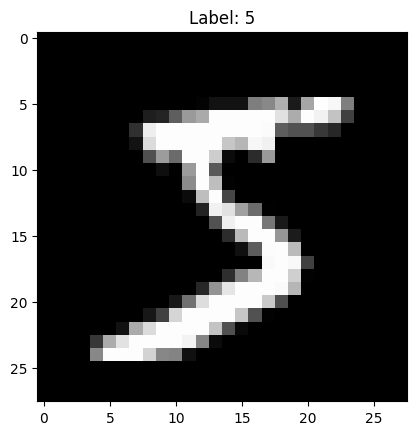

In [5]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

# Display the first image in the training set
plt.imshow(train_images[0].squeeze(), cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()

In [17]:
len(train_images) 

50

In [18]:
len(train_images) 

50


### Quantum Circuit as a Convolution Kernel

1. **Initializing the Quantum Device**:
   We set up a quantum simulator using PennyLane’s `default.qubit` device. This simulator represents a quantum system consisting of 4 qubits, which will be used to perform quantum computations for convolution operations.

2. **Quantum Circuit Components**:
   - **Embedding Layer**: This layer involves applying local `R_y` rotations to each qubit. The angles for these rotations are scaled by a factor of π. This embedding prepares the qubits for further quantum operations.
   - **Random Circuit**: A quantum circuit with `n_layers` is used to introduce variability and complexity. This random circuit serves as the convolution kernel, processing the input data.
   - **Measurement**: The quantum circuit is measured in the computational basis, yielding 4 expectation values. These values represent the output of the quantum convolution operation, capturing the features extracted by the quantum circuit.

By following these steps, we integrate quantum computing into image processing tasks, leveraging the unique capabilities of quantum circuits to perform convolution operations on the MNIST dataset.

### Defining the Convolution Scheme

In this section, we describe the process of applying a quantum convolutional scheme to an image. This process involves several key steps:

1. **Dividing the Image into Local Regions**:
   - The image is partitioned into small squares, each measuring \(2 \times 2\) pixels. This segmentation allows us to process localized regions of the image independently, which is crucial for convolutional operations.

2. **Processing Each Square with the Quantum Circuit**:
   - Each \(2 \times 2\) pixel square is fed into the quantum circuit. This circuit, which consists of parameterized quantum gates, performs a series of quantum operations on the qubits representing the pixel values. The quantum computation associated with each local region generates a set of expectation values.

3. **Mapping Expectation Values to Output Channels**:
   - After processing each \(2 \times 2\) pixel square, the quantum circuit outputs 4 expectation values. These values are then mapped to 4 different channels of a single output pixel. Essentially, each expectation value contributes to a different feature channel, capturing distinct aspects of the local region.

This convolution scheme results in a reduction of the image resolution. Specifically, the original image resolution is halved, akin to performing a convolution with a \(2 \times 2\) kernel and a stride of 2 in traditional convolutional neural networks (CNNs). This stride effectively down-samples the image, reducing its size while preserving essential features extracted by the quantum convolution operation.

In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [7]:
# Example input to the circuit
phi = np.random.uniform(size=4)
# Draw the circuit
drawer = qml.draw(circuit)
print(drawer(phi))

0: ──RY(1.33)─╭RandomLayers(M0)─┤  <Z>
1: ──RY(2.03)─├RandomLayers(M0)─┤  <Z>
2: ──RY(1.37)─├RandomLayers(M0)─┤  <Z>
3: ──RY(2.80)─╰RandomLayers(M0)─┤  <Z>


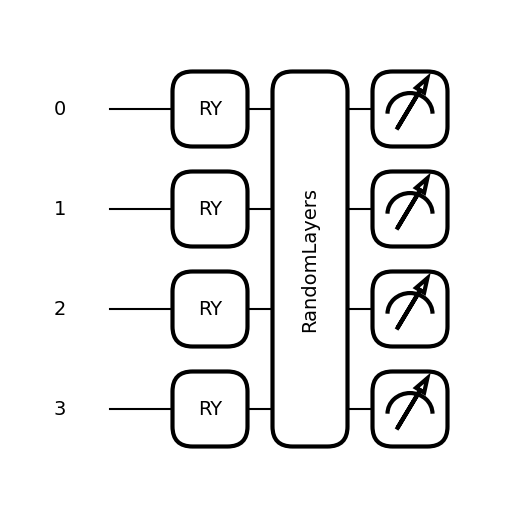

In [8]:
# Draw the circuit
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit)(np.random.randn(4 ))
plt.show()

In [9]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Quantum Pre-Processing of the Dataset

In this section, we focus on the efficiency and implementation of the quantum convolution layer as a pre-processing step for the dataset. Here’s a detailed breakdown of the approach:

1. **Purpose of Quantum Pre-Processing**:
   - The quantum convolution layer is not intended to be trained directly within this setup. Instead, it serves as a pre-processing step for all images in the dataset. By applying this quantum convolution layer upfront, we transform the raw image data into a form that is suitable for subsequent classical machine learning models.

2. **Efficiency Considerations**:
   - Applying the quantum convolution layer as a pre-processing step enhances efficiency by avoiding redundant quantum computations. Training a classical model on the transformed data eliminates the need for repeated evaluations of the quantum circuit during each training iteration. This approach significantly reduces the computational overhead associated with quantum processing.

3. **Saving and Loading Pre-Processed Data**:
   - The pre-processed images are stored in a designated folder, specified by `SAVE_PATH`. This storage allows for easy access and reuse of the transformed dataset without reapplying the quantum convolution layer each time the code runs.
   - To facilitate flexible usage, you can choose whether to preprocess the data afresh or use pre-processed images. If `PREPROCESS` is set to `False`, the code will load the images from the saved files in `SAVE_PATH`. Conversely, if `PREPROCESS` is set to `True`, the quantum convolution layer is applied to the dataset during each run, ensuring that the latest transformation is used.

This approach optimizes computational resources and streamlines the workflow by leveraging quantum computation as a one-time pre-processing step.

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


### Visualization of Quantum Convolution Output

After applying the quantum convolution layer to each input image, the resulting four output channels are displayed in grayscale. This visualization reveals several key characteristics:

1. **Resolution and Downsampling**:
   - The quantum convolution process results in a noticeable reduction in resolution. Each output channel corresponds to a downsampled version of the original image, where the resolution is effectively halved. This is expected behavior for a convolution operation with a \(2 \times 2\) kernel and a stride of 2.

2. **Local Distortion**:
   - The output channels may exhibit some local distortions due to the quantum convolution kernel's inherent properties. These distortions arise from the quantum processing and differ from standard classical convolution layers.

3. **Preservation of Global Structure**:
   - Despite the downsampling and local distortions, the global shape and structure of the original image are largely preserved. This preservation is typical of convolution layers, which focus on capturing essential features and patterns within the data.



In [ ]:
#Let us visualize the effect of the quantum convolution layer on a batch of samples:

n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


### Hybrid Quantum-Classical Model

Following the quantum convolution step, the next phase involves integrating the quantum-processed features into a classical neural network for digit classification. Here’s how this is structured:

1. **Model Architecture**:
   - The classification model used in this setup is a straightforward neural network comprising a single fully connected (dense) layer. This layer has 10 output nodes, corresponding to the 10 possible digits in the MNIST dataset. A softmax activation function is applied at the output layer to convert the network's raw predictions into class probabilities.

2. **Model Compilation**:
   - The neural network is compiled with the following configuration:
     - **Optimizer**: A stochastic gradient descent (SGD) optimizer is employed to update the model weights based on the loss gradient.
     - **Loss Function**: The cross-entropy loss function is used, which is suitable for multi-class classification problems. It measures the difference between the predicted class probabilities and the true class labels.

By combining the quantum convolution pre-processing with a classical neural network, this hybrid approach leverages the strengths of both quantum and classical methodologies to achieve effective digit classification on the MNIST dataset.

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training the Hybrid Quantum-Classical Model

#### Model Initialization
The training process begins with initializing the instance of the neural network model. This involves creating a new object of the model class with the specified architecture:

- **Model Instance**: We instantiate the neural network, which includes setting up the single fully connected (dense) layer with 10 output nodes and the softmax activation function.

#### Training and Validation
Once the model is initialized, we proceed with training and validating it using the pre-processed dataset:

1. **Dataset Preparation**:
   - **Pre-Processed Data**: The dataset used for training and validation has already undergone quantum convolution pre-processing. This means that the input images have been transformed by the quantum convolution layer, resulting in feature maps that serve as the new input data for the neural network.

2. **Training Process**:
   - **Training Phase**: The model is trained using the pre-processed features from the training set. During this phase, the stochastic gradient descent (SGD) optimizer updates the model weights to minimize the cross-entropy loss function. The model learns to classify the digits based on the processed image features.

3. **Validation Phase**:
   - **Validation**: After training, the model’s performance is evaluated on a separate validation set. This set contains pre-processed images that were not seen by the model during training. Validation helps assess the model’s generalization ability and ensures it performs well on unseen data.

By following this procedure, we leverage the quantum convolution layer’s ability to extract complex features from the MNIST images, while the classical neural network focuses on learning to classify these features accurately. This hybrid approach combines the strengths of quantum processing with traditional machine learning techniques for effective digit classification.

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

### Comparing Results with and without Quantum Convolution

To evaluate the effectiveness of the quantum convolution layer, we conduct a comparison between two models:

1. **Quantum-Enhanced Model**:
   - **Quantum Pre-Processing**: This model is first pre-processed with the quantum convolution layer. The raw MNIST images are transformed into feature maps by the quantum circuit before being fed into the neural network.
   - **Training**: The network is trained and validated using these quantum-processed features.

2. **Classical Model**:
   - **Direct Training**: In this instance, we initialize a model identical in architecture to the quantum-enhanced one, but it is trained and validated directly on the raw MNIST images without any quantum pre-processing.
   - **Pre-Processing**: The input data for this model remains in its original form, and no quantum convolution is applied.

#### Steps for Comparison

1. **Model Initialization**:
   - **Quantum Model**: Initialize the model that includes the quantum convolution pre-processing layer followed by the fully connected layer.
   - **Classical Model**: Initialize a similar neural network model but without the quantum convolution pre-processing step.

2. **Training**:
   - **Quantum Model**: Train the model using the quantum-processed images. This involves feeding the feature maps obtained from the quantum convolution layer into the neural network.
   - **Classical Model**: Train the model directly with the raw MNIST images. The training process utilizes standard image data without quantum transformations.

3. **Validation**:
   - **Quantum Model**: Validate the performance using pre-processed validation images. This checks how well the model generalizes to new data after quantum feature extraction.
   - **Classical Model**: Validate the performance using raw MNIST images. This evaluates how well the model performs on the original data without quantum enhancements.

By comparing the results from both models, we can assess the impact of the quantum convolution layer on classification performance. This comparison highlights whether the quantum pre-processing offers any advantage over traditional methods or if the classical model achieves comparable results.

### Results

To evaluate and compare the performance of the quantum-enhanced model and the classical model, we analyze their test accuracy and test loss over the training epochs.

#### Plotting Test Accuracy and Test Loss

1. **Test Accuracy**:
   - **Purpose**: To measure how well each model classifies unseen data after training.
   - **Plot Description**: The plot displays the test accuracy as a function of the number of training epochs. Accuracy is calculated as the proportion of correctly classified test samples out of the total test samples.
   - **Details**: Each curve on the plot represents the test accuracy for one of the models—quantum-enhanced or classical—over the training process. This helps in understanding how quickly and effectively each model improves in terms of accuracy.

2. **Test Loss**:
   - **Purpose**: To assess the error or the discrepancy between the predicted and actual labels for the test set.
   - **Plot Description**: The plot illustrates the test loss as a function of the number of training epochs. Loss quantifies the difference between the predicted probabilities and the true class labels, with lower values indicating better performance.
   - **Details**: Similar to the accuracy plot, each curve represents the test loss for the quantum-enhanced and classical models over the training epochs. This plot reveals how the error rate decreases or changes during training.

#### Interpretation

- **Accuracy Trends**: Look for which model achieves higher accuracy and if one model converges faster than the other.
- **Loss Trends**: Observe which model achieves lower test loss and how the loss value evolves during training.

By analyzing these plots, we can draw conclusions about the relative performance of the quantum convolution layer compared to the classical approach, providing insights into the effectiveness and potential benefits of incorporating quantum techniques in machine learning models.

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("classic")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy",fontsize=20  )
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch",fontsize=20 )
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss",fontsize=20 )
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch",fontsize=20 )
ax2.legend()
plt.tight_layout()
plt.show()


References¶
Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019.

In [ ]:
%pip install -q seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming q_history and c_history are available
# Example:
# q_history = model_with_quantum_layer.fit(...)  # History object of the quantum-enhanced model
# c_history = model_without_quantum_layer.fit(...)  # History object of the classical model

# Using seaborn style for better aesthetics
plt.style.use("classic")

# Creating subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Plotting Test Accuracy
ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_title("Test Accuracy over Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.grid(True)

# Plotting Test Loss
ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_title("Test Loss over Epochs")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()
